# 小作业三： 夏普利值与简单多智能体学习算法

同学们此前的课上已经了解了夏普利值与一些经典的多智能体学习算法。在这次作业用，你们将会回顾之前的知识，并用python来加深对这些知识的理解。

## 目录

本次作业主要分为以下几个部分：
- 夏普利值
    - 夏普利值计算
- 虚拟互搏
    - Fictitious Play算法实现
    - 扩展实验与结果分析
- 随机博弈
    - 随机博弈环境初始化
    - Q-Learning
    - 多智能体学习算法扩展

## 提交说明：
请同学们在canvas上提交，本次作业满分100分，占总成绩15%。

**注意，请同学们在提交的版本中不要添加和删改notebook中的函数名，我们会根据这些实现的函数来进行评分。如有其他问题，请联系助教。**

提交文件名设置为 `{姓名}_{学号}_hw3.ipynb`，如`小明_123_hw3.ipynb`.


## 夏普利值（共20分）

今有A、B、C三位商人考虑合作完成一系列订单。对于每个订单，A、B、C单干时分别能获利0、0、1万元，A、B合作共能获利6万元，A、C合作共能获利5万元，B、C合作则共能获利3万元。今A、B、C三人共同合作完成了一个订单，一共获利了10万元，按照夏普利的方法，三人该如何分配这10万获利？

为方便表示，各重组合获利情况如下表：
|联盟 $s$|$\{A\}$|$\{B\}$|$\{C\}$|$\{A,B\}$|$\{A,C\}$|$\{B,C\}$|$\{A,B,C\}$|
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
|联盟收益 $v(s)$|0|0|1|6|5|3|10|

根据以上信息，请站在甲的角度，估算甲应分得的利润，并填充以下的表格与 $\psi_A$ （10分）：
|包含A的联盟|$\{A\}$|$\{A,B\}$|$\{A,C\}$|$\{A,B,C\}$|
|:---:|:---:|:---:|:---:|:---:|
|联盟收益 $v(s)$|0|6|5|10|
|A的边际贡献 $v(s)-v(s$ \\ $\{A\})$|0|6|4|7|
|权重系数 $w(s)$|$\dfrac{1}{3}$|$\dfrac{1}{6}$|$\dfrac{1}{6}$|$\dfrac{1}{3}$|

A应分得得利润 $\psi_A=0 \cdot \dfrac{1}{3} + 6 \cdot \dfrac{1}{6} + 4 \cdot \dfrac{1}{6} + 7 \cdot \dfrac{1}{3} = 4$

并补充下面代码中的 `TODO` 部分，用以计算出A、B、C三人各自的应得利润（夏普利值）并填入下表（10分）。
|商人|$A$|$B$|$C$|
|:---:|:---:|:---:|:---:|
|夏普利值 $\psi$|4|3|3|

In [2]:
import math

N_PLAYER = 3
PLAYER_LIST = ['A', 'B', 'C']

V_S = {
    'A': 0,
    'B': 0,
    'C': 1,
    'AB': 6,
    'AC': 5,
    'BC': 3,
    'ABC': 10
}

# 计算边际贡献
def cal_margin(coalition, player):
    ################# TODO #################
    margin = []
    for i in coalition.keys():
        if i.find(player) != -1:
            value = coalition[i]
            margin_condition = i.replace(player, '')
            if margin_condition == "":
                margin_value = 0
            else:
                margin_value = coalition[margin_condition]
            margin.append(value - margin_value)
        else:
            margin.append(0)
    ############### END TODO ###############
    return margin


# 计算权重系数
def cal_weights(n_player, coalition):
    ################# TODO #################
    weights = []
    for i in coalition.keys():
        weight = math.factorial(
            len(i) - 1) * math.factorial(n_player - len(i)) / math.factorial(n_player)
        weights.append(weight)
    ############### END TODO ###############
    return weights

# 计算夏普利值
def cal_shapley(n_player, player_list, v_s):
    shapley_value_list = []
    for i in range(n_player):
        ################# TODO #################
        margin = cal_margin(v_s, player_list[i])
        weights = cal_weights(n_player, v_s)
        shapley_value = sum(margin[i] * weights[i] for i in range(len(margin)))
        ############### END TODO ###############
        shapley_value_list.append(shapley_value)
    return shapley_value_list
        
# 测试入口
shapley_values = cal_shapley(N_PLAYER, PLAYER_LIST, V_S)
for i in range(N_PLAYER):
    print("Shapley value for {} is: {}".format(PLAYER_LIST[i], shapley_values[i]))



Shapley value for A is: 3.9999999999999996
Shapley value for B is: 3.0
Shapley value for C is: 3.0


## 矩阵博弈（共40分）

#### Fictitious Play

让我们继续故事一种的故事，一段时间后，有互相竞争的两位商人C和D也想与A, B, C合作，C, D均可以分别与A, B, C中的任意一人沟通。此时，C(左侧), D(上部)分别选择与A, B, C任意一人沟通的回报矩阵如下：

|       | A  | B | C |
|-------|-------|-------|----------|
| A  | 0, 0  | -1, 1 | 1, -1    |
| B | 1, -1 | 0, 0  | -1, 1    |
| C | -1, 1 | 1, -1 | 0, 0 |

请补充以下代码中的`TODO`部分，实现Fictitious Play算法用以计算100轮之后的C和D的belief与回报（25分）。

In [41]:
import random
import numpy as np
# 定义动作与回报矩阵
ACTIONS = ["A", "B", "C"]
PAYOFF = [[[0, 0], [-1, 1], [1, -1]], 
          [[1, -1], [0, 0], [-1, 1]], 
          [[-1, 1], [1, -1], [0, 0]]]
random.seed(366)

# 根据C, D的动作获取回报
def get_payoff(action_c, action_d):
    return PAYOFF[action_c][action_d]

# 根据belief选择动作(计算Best Response)
def select_action(belief_c, belief_d):
    ################# TODO #################

    # get probability for each action
    prob_c = np.array(belief_c) / np.sum(belief_c)
    prob_d = np.array(belief_d) / np.sum(belief_d)
    # calculate best response for c
    response_c = [0,0,0]
    for c_action in range(len(ACTIONS)):
        for d_action in range(len(ACTIONS)):
            response_c[c_action] += PAYOFF[c_action][d_action][0] * prob_d[d_action]
    # calculate best response for d
    response_d = [0,0,0]
    for d_action in range(len(ACTIONS)):
        for c_action in range(len(ACTIONS)):
            response_d[d_action] += PAYOFF[c_action][d_action][1] * prob_c[c_action]
    # get action with max response
    action_c = np.argmax(response_c)
    action_d = np.argmax(response_d)

    return action_c, action_d
    ############### END TODO ###############


# Fictitious Play流程
def fictitious_play(rounds):
    
    # 请初始化c和d的beliefs
    ################# TODO #################
    # 随机初始化
    belief_c = [random.randint(1, 5) for i in range(3)]
    belief_d = [random.randint(1, 5) for i in range(3)]
    print(f"Initial C's belief: {belief_c}")
    print(f"Initial D's belief: {belief_d}")
    ############### END TODO ###############

    for i in range(rounds):
        action_c, action_d = select_action(belief_c, belief_d)
        payoff_c, payoff_d = get_payoff(action_c, action_d)

        # 更新C与D的beliefs
        ################# TODO #################
        belief_c[action_c] += payoff_c
        belief_d[action_d] += payoff_d
        ############### END TODO ###############

    # Return the empirical frequencies and the average payoffs for both players as a tuple
    return belief_c, belief_d, payoff_c, payoff_d

# Fictitious Play重复轮数
rounds = 100
for _ in range(1):
    belief_c, belief_d, payoff_c, payoff_d = fictitious_play(rounds)
    print(f"C's belief: {belief_c}")
    print(f"D's belief: {belief_d}")
    print(f"C's payoff: {payoff_c}")
    print(f"D's payoff: {payoff_d}")
    print("=" * 40)

Initial C's belief: [1, 4, 1]
Initial D's belief: [2, 5, 4]
C's belief: [1, 4, 1]
D's belief: [2, 5, 4]
C's payoff: 0
D's payoff: 0


In [52]:
rounds = 100
cnt = 0
for _ in range(1000):
    belief_c, belief_d, payoff_c, payoff_d = fictitious_play(rounds)
    if payoff_c != 0 or payoff_d != 0:
        print("=" * 40)
        cnt += 1
    print(f"C's belief: {belief_c}")
    print(f"D's belief: {belief_d}")
    print(f"C's payoff: {payoff_c}")
    print(f"D's payoff: {payoff_d}")
        
print('Errors:', cnt)

Initial C's belief: [1, 4, 5]
Initial D's belief: [2, 2, 1]
C's belief: [1, 3, 5]
D's belief: [2, 2, 2]
C's payoff: 0
D's payoff: 0
Initial C's belief: [5, 2, 3]
Initial D's belief: [5, 5, 5]
C's belief: [4, 2, 2]
D's belief: [6, 6, 5]
C's payoff: 0
D's payoff: 0
Initial C's belief: [3, 1, 5]
Initial D's belief: [4, 1, 5]
C's belief: [3, 1, 5]
D's belief: [4, 1, 5]
C's payoff: 0
D's payoff: 0
Initial C's belief: [4, 3, 4]
Initial D's belief: [2, 1, 4]
C's belief: [4, 3, 4]
D's belief: [2, 1, 4]
C's payoff: 0
D's payoff: 0
Initial C's belief: [1, 3, 2]
Initial D's belief: [3, 5, 1]
C's belief: [1, 3, 2]
D's belief: [3, 5, 1]
C's payoff: 0
D's payoff: 0
Initial C's belief: [1, 5, 2]
Initial D's belief: [2, 5, 2]
C's belief: [1, 5, 2]
D's belief: [2, 5, 2]
C's payoff: 0
D's payoff: 0
Initial C's belief: [2, 4, 1]
Initial D's belief: [2, 2, 2]
C's belief: [3, 4, 1]
D's belief: [2, 2, 1]
C's payoff: 0
D's payoff: 0
Initial C's belief: [1, 1, 5]
Initial D's belief: [3, 4, 1]
C's belief: [1, 

利用你补全的代码，请继续尝试多几组不同的初始belief以及更多的重复轮数，记录你的实验结果并进行分析分析（提示：关注结果体现的belief、payoff与Nash equilibrium三者之间的关系）（15分）。

我重复了1000次实验，随机初始化了100组不同的初始belief，每组实验进行了100轮，记录了发生纳什均衡的情况, 结果如上面的text中记录所示。

通过分析这些数据，我发现，当belief初始化具有偏向性的时候，比如对于C，初始化明显偏向B，那么在play的过程中D的belief会逐渐偏向B，最终会收敛到B，这时候C和D的payoff都是0，达到了纳什均衡。反之也适用于D。但是如果初始化的时候C和D的belief都是均匀的，那么在play的过程中，C和D的belief都会逐渐偏向A，最终会收敛到A，这时候C和D的payoff都是0，达到了纳什均衡。所以我认为，当初始化的时候，C和D的belief都是均匀的时候，C和D的payoff都是0，达到了纳什均衡。至于发生的初始化均匀时偏向A的情况，个人认为是因为numpy的取argmax的时候，如果有多个最大值，会取第一个，所以会偏向A。

除此之外，我还将轮数作为自变量研究了它与belief收敛的关系。

|rounds|1|3|5|10|20|100|
|-|-|-|-|-|-|-|
|Errors|647|359|79|0|0|0|

由此可见，belief在轮数达到20轮的时候就已经渐进收敛。



## 随机博弈（共40分）

#### 初始化随机博弈

某天，商人A与B收到了一批未曾接触过的新订单，每一个订单均分为多个不同的步骤，且每个步骤需要A、B二人通力合作才能完成，最终能取得的共同利润也与二人在这些步骤中所做的决策相关。由于A、B此前均无这类订单的经验，他们需要从零开始探索最佳的合作方案，以谋求利润的最大化。

如果我们站在上帝视角，完成新订单的过程可以用下图中的随机博弈表示：

![Stochastic Game](sg.png)

该博弈一共包括5个阶段，其中中间矩阵代表博弈的初始状态，根据二人的联合动作存在着两个分支，分别导向最左最右两个终止阶段。如图所示，除初始与终止状态外，左右两个分支的中间阶段均为连续三次的的重复博弈。A与B均只有两种可能的动作 $\{0,1\}$ （A为行，B为列），且矩阵对应位置的数值代表相应阶段A、B执行联合动作后所共同获得的即时回报，其中的红色标志意味着A、B执行对应联合动作后博弈将提前结束。A、B所获的的总回报为各阶段即时回报之和。

Note：从上帝视角看，不难看出该随机博弈的最优联合动作序列为 $\{(0,0), (0,0), (0,0), (0,0), (1,1)\}$，此时获得的最优总回报为8。但商人A、B并没有上帝视角，他们能观察到的信息仅包括当前所处的阶段与分支。

在这个练习中，同学们需要利用所学的知识，实现属于自己的智能体，以模拟商人A和B探寻最佳合作方案（策略）的过程。 下面是初始化该随机博弈环境的代码，如有需要，环境的细节信息可以从代码中获得。

In [3]:
import numpy as np


class StochasticGame():
    def __init__(self, episode_limit=5, good_branches=2, batch_size=None, **kwargs):
        # Define the agents
        self.n_agents = 2

        self.episode_limit = episode_limit

        # Define the internal state
        self.steps = 0

        r_matrix = [[1,1],[1,1]]
        self.payoff_values = [r_matrix for _ in range(self.episode_limit)]
        self.final_step_diff =[[1,1],[1,4]]

        self.branches = 4
        self.branch = 0

        self.n_actions = len(self.payoff_values[0])

        self.good_branches = good_branches

    def reset(self):
        """ Returns initial observations and states"""
        self.steps = 0
        self.branch = 0
        return self.get_obs()

    def step(self, actions):
        """ Returns reward, terminated, info """
        current_branch = 0
        if (actions[0], actions[1]) == (0,0):
            current_branch = 0
        if (actions[0], actions[1]) == (0,1):
            current_branch = 1
        if (actions[0], actions[1]) == (1,0):
            current_branch = 2
        if (actions[0], actions[1]) == (1,1):
            current_branch = 3

        if self.steps == 0:
            self.branch = current_branch

        info = {}

        info["good_payoff"] = 0
        info["branch"] = self.branch

        if self.good_branches == 4:
            reward = 1 if self.branch == current_branch else 0 # Need to follow your branch
        elif self.good_branches == 2:
            reward = 1 if self.branch in [0,3] and self.branch == current_branch else 0
        else:
            raise Exception("Environment not setup to handle {} good branches".format(self.good_branches))

        if self.episode_limit > 1 and self.steps == self.episode_limit - 1 and self.branch == 0:
            info["good_payoff"] = 1
            reward = self.final_step_diff[actions[0]][actions[1]]

        self.steps += 1

        if self.steps < self.episode_limit and reward > 0:
            terminated = False
        else:
            terminated = True

        info["episode_limit"] = False

        # How often the joint-actions are taken
        info["action_00"] = 0
        info["action_01"] = 0
        info["action_10"] = 0
        info["action_11"] = 0
        if (actions[0], actions[1]) == (0, 0):
            info["action_00"] = 1
        if (actions[0], actions[1]) == (0, 1):
            info["action_01"] = 1
        if (actions[0], actions[1]) == (1, 0):
            info["action_10"] = 1
        if (actions[0], actions[1]) == (1, 1):
            info["action_11"] = 1

        return self.get_obs(), [reward] * 2, [terminated] * 2, info

    def get_obs(self):
        """ Returns all agent observations in a list """
        one_hot_step = [0] * (self.episode_limit + 1 + self.branches)
        one_hot_step[self.steps] = 1
        one_hot_step[self.episode_limit + 1 + self.branch] = 1
        return [tuple(one_hot_step) for _ in range(self.n_agents)]

    def get_obs_agent(self, agent_id):
        """ Returns observation for agent_id """
        return self.get_obs()[agent_id]

    def get_obs_size(self):
        """ Returns the shape of the observation """
        return len(self.get_obs_agent(0))

    def get_state(self):
        return self.get_obs_agent(0)

    def get_state_size(self):
        """ Returns the shape of the state"""
        return self.get_obs_size()

    def get_total_actions(self):
        """ Returns the total number of actions an agent could ever take """
        return self.n_actions


#### 随机策略

我们提供了一个简单的随机策略作为基类与例子方便大家了解环境。

In [4]:
from collections import defaultdict
from functools import partial
from abc import ABCMeta, abstractmethod
import random

import numpy as np

def sample(pi):
  return np.random.choice(pi.size, size=1, p=pi)[0]

def normalize(pi):
    minprob = np.min(pi)
    if minprob < 0.0:
        pi -= minprob
    pi /= np.sum(pi)

class BaseQAgent:
    def __init__(self, name, action_num=2, phi=0.01, gamma=0.95, episilon=0.1, **kwargs):
        self.name = name
        self.action_num = action_num
        self.episilon = episilon
        self.gamma = gamma
        self.phi = phi
        self.epoch = 0
        self.Q = None
        self.pi = defaultdict(partial(np.random.dirichlet, [1.0] * self.action_num))

    def done(self):
        pass

    def act(self, observation, exploration=False):
        if exploration and random.random() < self.episilon:
            return random.randint(0, self.action_num - 1)
        else:
            return sample(self.pi[observation])

    @abstractmethod
    def update(self, observation, action, reward, next_observation, done):
        pass

    @abstractmethod
    def update_policy(self, observation, action):
        pass

#### Q-Learning

作为马尔可夫决策场景中一个经典的单智能体算法，Q-Learning的策略更新过程可以表示为：

$$
Q(s, a) \leftarrow(1-\phi) Q(s, a)+\phi\left(r+\gamma V\left(s^{\prime}\right)\right)
$$

其中，
$$
V(s)=\max\left(\left[Q(s, a)_{a \in \mathcal{A}}\right]\right)
$$

请同学先尝试着用基于Q-Learning的智能体来解决上面的随机博弈问题，补充下方代码中的 `TODO` 部分（10分）。

In [5]:
class QAgent(BaseQAgent):
    def __init__(self, **kwargs):
        super().__init__('QAgent', **kwargs)
        self.Q = defaultdict(partial(np.random.rand, self.action_num))
        self.R = defaultdict(partial(np.zeros, self.action_num))
        self.count_R = defaultdict(partial(np.zeros, self.action_num))

    def done(self):
        self.R.clear()
        self.count_R.clear()

    def update(self, observation, action, reward, next_observation, done):
        self.count_R[observation][action] += 1.0
        self.R[observation][action] += (reward - self.R[observation][action]) / self.count_R[observation][action]
        Q = self.Q[observation]
        V = self.val(next_observation)
        
        # 请实现Q的更新过程
        ################# TODO #################
        self.Q[observation][action] = (1 - self.phi) * Q[action] + self.phi * (reward + self.gamma * V)
        ############### END TODO ###############
        self.update_policy(observation, action)
        self.epoch += 1

    def val(self, observation):
        # 请实现V的计算
        ################# TODO #################
        v = max(self.Q[observation])
        ############### END TODO ###############
        return v

    def update_policy(self, observation, action):
        Q = self.Q[observation]
        self.pi[observation] = (Q == np.max(Q)).astype(np.double)
        self.pi[observation] = self.pi[observation] / np.sum(self.pi[observation])
  

以下为测试与绘图代码，你可以通过运行以下代码来观察你实现的智能体的表现。

In [6]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from copy import deepcopy

def rollout(env, agents, exploration=True, max_episode=30000, log_episode_interval=500, verbose=False):
  history_reward = []
  state_n = env.reset()
  episode_reward = 0
  episode_count = 0
  recorded_episodes = []
  recorded_episode_reward = []
  while episode_count < max_episode:
      actions = np.array([agent.act(state, exploration) for state, agent in zip(state_n, agents)])
      next_state_n, reward_n, done_n, _ = env.step(actions)
      episode_reward += np.mean(reward_n)
      for j, (state, reward, next_state, done, agent) in enumerate(zip(state_n, reward_n, next_state_n, done_n, agents)):
          agent.update(state, actions[j], reward, next_state, done)
      state_n = next_state_n
      if np.all(done_n):
          state_n = env.reset()
          history_reward.append(episode_reward)
          episode_reward = 0
          episode_count += 1
          if episode_count % log_episode_interval == 0:
            recorded_episodes.append(episode_count)
            episodes_mean_reward = np.mean(history_reward)
            recorded_episode_reward.append(episodes_mean_reward)
            history_reward = []
            if verbose:
                print('Episodes {}, Reward {}'.format(episode_count, episodes_mean_reward))
  return recorded_episodes, recorded_episode_reward

In [7]:
agent_num = 2
action_num = 2

runs = 10
log_episode_interval = 500
train_recorded_episodes_log = []
train_recorded_episode_reward_log = []
test_recorded_episode_reward_log = []

for i in range(runs):
  ##################################### INITIALISATION ####################################
  agents = []
  env = StochasticGame()
  for i in range(agent_num):
      agent = QAgent(action_num=action_num)
      agents.append(agent)

  ####################################### TRAINING #######################################
  train_recorded_episodes, train_recorded_episode_reward = rollout(env=env, 
                                                                  agents=agents, 
                                                                  exploration=True,
                                                                  max_episode=30000,
                                                                  log_episode_interval=log_episode_interval)
  train_recorded_episodes_log.append(train_recorded_episodes)
  train_recorded_episode_reward_log.append(train_recorded_episode_reward)

  ####################################### TESTING #######################################
  test_recorded_episodes, test_recorded_episode_reward = rollout(env=env, 
                                                               agents=agents, 
                                                               exploration=False, 
                                                               max_episode=10, 
                                                               log_episode_interval=1)
  test_recorded_episode_reward_log.append(np.mean(test_recorded_episode_reward))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


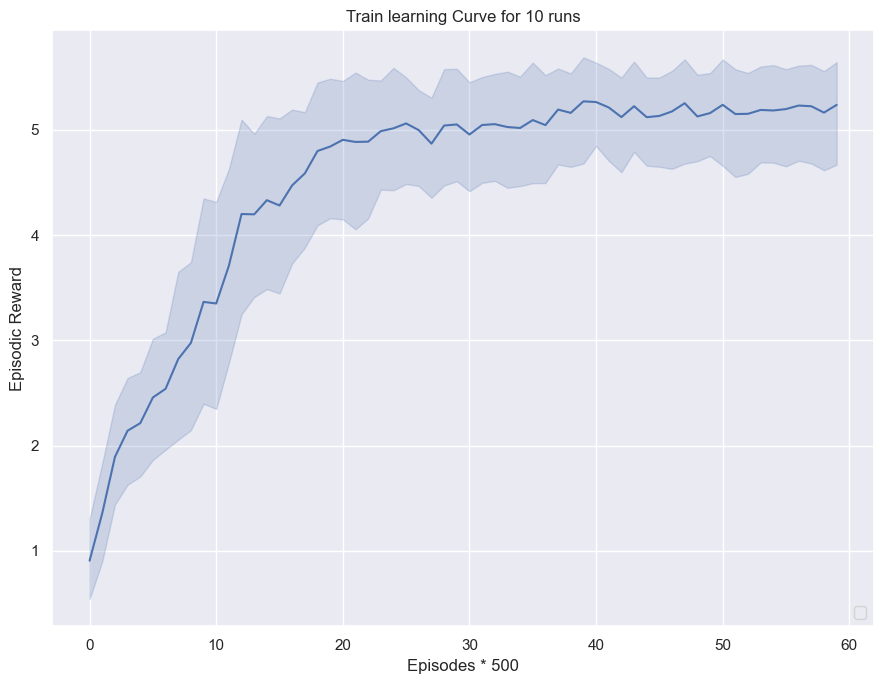

Test reward is (average over 10 runs): 7.4


In [8]:
####################################### TRAINING #######################################

import seaborn as sns; sns.set()
import pandas as pd
fig = plt.figure(figsize=(9, 7))
ax = fig.add_subplot(111)
df_reward = pd.DataFrame(train_recorded_episode_reward_log).melt()
sns.lineplot(ax=ax, x='variable', y='value', data=df_reward)
ax.set_title(f"Train learning Curve for {runs} runs")
ax.set_ylabel("Episodic Reward")
ax.set_xlabel("Episodes * " + str(log_episode_interval))
ax.legend(loc="lower right")
plt.tight_layout()
plt.show()

####################################### TESTING #######################################
print(f'Test reward is (average over {runs} runs):', np.mean(test_recorded_episode_reward_log))

#### 多智能体学习算法扩展

观察Q-Learning的表现，是否有更好的方法去解决这个随机博弈问题呢？实现并训练一个完全属于你的智能体来更好地解决这个问题吧！简单与Q-Learning比较，分析下两种方法的异同与优缺。

Note: 你可能需要考虑一些策略探索的方法。这里列出了一些可供参考的方法，当然，你的选择并不局限于此：
1. [Minimax Q-Learning](https://arxiv.org/abs/1906.06659)
2. [Nash Q-Learning](https://jmlr.csail.mit.edu/papers/volume4/hu03a/hu03a.pdf)
3. [Friend-or-Foe Q-Learning](https://www.researchgate.net/publication/2933305_Friend-or-Foe_Q-learning_in_General-Sum_Games)
4. [WOLF-PHC](https://www.sciencedirect.com/science/article/pii/S0004370202001212)
5. [PGA-APP](https://www.researchgate.net/publication/220269223_Multi-Agent_Learning_with_Policy_Prediction)


请补充下面代码的 `TODO` 部分（20分）。

In [9]:
# 你可以在这里按你的想法实现属于你的智能体！
# 不过请保持接口能跟上面的环境对上，以便验证
################# TODO #################
class MyAgent(BaseQAgent):
    def __init__(self, **kwargs):
        super().__init__('CoolAgent', **kwargs)
        self.Q = defaultdict(partial(np.random.rand, self.action_num))
        self.R = defaultdict(partial(np.zeros, self.action_num))
        self.count_R = defaultdict(partial(np.zeros, self.action_num))
        self.cauchy = 1
    def done(self):
        self.R.clear()
        self.count_R.clear()

    def act(self, observation, exploration):
        if exploration and random.random() < self.episilon:
            return random.randint(0, self.action_num - 1)
        else:
            return sample(self.pi[observation])

    def update(self, observation, action, reward, next_observation, done):
        self.count_R[observation][action] += 1.0
        self.R[observation][action] += (reward - self.R[observation]
                                        [action]) / self.count_R[observation][action]
        self.Q[observation][action] = (1 - self.phi) * self.Q[observation][action] + \
            self.phi * (reward + self.gamma * max(self.Q[next_observation]))
        self.update_policy(observation, action)
        self.epoch += 1

    def val(self, observation):
        return sum(self.Q[observation] * self.pi[observation])

    def update_policy(self, observation, action):
        for action_i in range(self.action_num):
            if self.pi[observation][action_i] == 1:
                delta_hat = self.Q[observation][action_i] - \
                    self.val(observation)
            else:
                delta_hat = (self.Q[observation][action_i] -
                             self.val(observation)) / (1 - self.pi[observation][action_i])
            delta = delta_hat - self.cauchy * \
                np.abs(delta_hat) * self.pi[observation][action_i]
            self.pi[observation][action_i] += self.phi * delta
            if self.pi[observation][action_i] < 0:
                self.pi[observation][action_i] = 0
            elif self.pi[observation][action_i] > 1:
                self.pi[observation][action_i] = 1
        self.pi[observation] = self.pi[observation] / \
            np.sum(self.pi[observation])
############### END TODO ###############

In [10]:
# 请在这里训练和调试你的智能体，记得最后把你的智能体赋值给test_agents哦
################# TODO #################
import tqdm

agent_num = 2
action_num = 2

runs = 10
log_episode_interval = 500
train_recorded_episodes_log = []
train_recorded_episode_reward_log = []

for i in tqdm.tqdm(range(runs)):
  # 初始化环境与智能体
  agents = []
  env = StochasticGame()
  for i in range(agent_num):
      agent = MyAgent(action_num=action_num)
      agents.append(agent)

  # 训练智能体
  train_recorded_episodes, train_recorded_episode_reward = rollout(env=env, 
                                                                             agents=agents, 
                                                                             exploration=True, 
                                                                             max_episode=30000,
                                                                             log_episode_interval=log_episode_interval)
  # 保存训练的log
  train_recorded_episodes_log.append(train_recorded_episodes)
  train_recorded_episode_reward_log.append(train_recorded_episode_reward)
  ############### END TODO ###############
  
  ####################################### TESTING #######################################
  test_agents = agents
  test_recorded_episode_reward_log = []
  # 测试代码，请勿修改
  test_env = StochasticGame()
  test_recorded_episodes, test_recorded_episode_reward = rollout(env=test_env, 
                                                                     agents=test_agents, 
                                                                     exploration=False, 
                                                                     max_episode=10, 
                                                                     log_episode_interval=1)
  test_recorded_episode_reward_log.append(np.mean(test_recorded_episode_reward))

100%|██████████| 10/10 [02:37<00:00, 15.74s/it]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


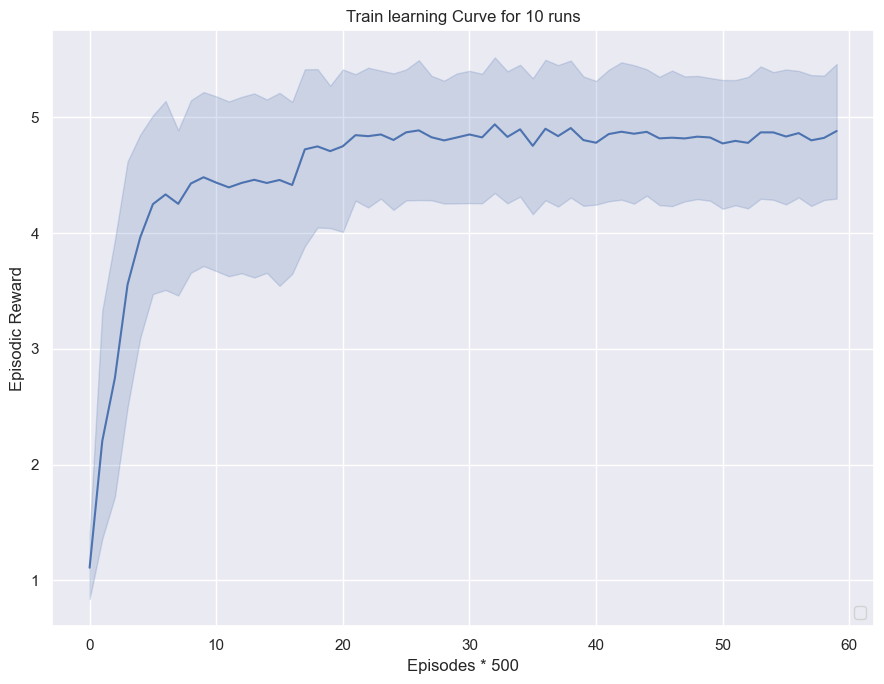

Cool agent's test reward is (average over 10 runs): 8.0


In [11]:
####################################### TRAINING #######################################
import seaborn as sns; sns.set()
import pandas as pd
fig = plt.figure(figsize=(9, 7))
ax = fig.add_subplot(111)
df_reward = pd.DataFrame(train_recorded_episode_reward_log).melt()
sns.lineplot(ax=ax, x='variable', y='value', data=df_reward)
ax.set_title(f"Train learning Curve for {runs} runs")
ax.set_ylabel("Episodic Reward")
ax.set_xlabel("Episodes * " + str(log_episode_interval))
ax.legend(loc="lower right")
plt.tight_layout()
plt.show()

print(f'Cool agent\'s test reward is (average over {runs} runs):', np.mean(test_recorded_episode_reward_log))

请在这里简短地描述下你的做法。重点阐述所选算法的核心思路，对比下其与Q-Learning的表现，分析其为何能在表现方面取得提升（小于500字）（10分）。

我使用了`PGA-APP`算法，其主要思想是将`Q-learning`与`IGA-PP`算法进行结合。一方面使用了`Q-Learning`来利用当前奖励更新当前价值，一方面利用 Q 值与 $\pi$ 值来计算loss，并进行策略的更新。

本算法在表现上与`Q-Learning`相对比，从图中可以清楚地看到，`Q-Learning`在训练后达到的average test reward 是 7.4，而本算法在训练后达到的average test reward 是 8.0。考虑到当前博弈环境，最优average test reward 即为 8.0。所以本算法在相同次数的训练后的表现比`Q-Learning`更好。这是一大优势。

本算法与`Q-Learning`相对比，主要提升在于：
1. 利用了`IGA-PP`算法的梯度上升思想，兼顾了自己与对方的策略，稳步进行提升。
2. 从某种角度讲，`PGA-APP`算法拓展了`Q-Learning`算法，使得它可以学习混合策略。
3. 仅需要观察一个智能体的策略，而不需要观察所有智能体的策略。

本算法与`IGA-PP`相比，主要提升在于：
1. 当策略达到纳什均衡时，梯度为0，不会进行进一步的更新，不影响策略达到纳什均衡的效果。这也节省了训练时间。
2. $-\gamma \mid \delta(s,\,a) \mid \pi(s,\,a)$ 的负号是为了模拟$u_r u_c < 0$ 的情况，而这种情况在`IGA-PP`算法中是无法收敛的。这种情况表明了博弈不再是合作博弈，而是竞争博弈。可以针对竞争博弈进行训练，而不会影响合作博弈的训练效果。
3. 仅需要观察一个智能体在选择特定动作后的奖励，不需要观察双方智能体的奖励，这样可以减少观察的次数，节省训练时间。